In [1]:
import time

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib as mpl
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn.cluster import DBSCAN
from sklearn.cluster import AffinityPropagation
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import MeanShift, estimate_bandwidth
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn import metrics
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.manifold import MDS
from math import floor
from scipy import stats
import seaborn as sns


# Función que ejecuta y muestra/guarda el algoritmo K-means

In [2]:
def kmeans(numero_clusters,data,datasinnorm):
    print('----- Ejecutando k-Means')  
    grafica = plt.figure(figsize=(16, 9))
    elbow = grafica.add_subplot(1,2,1) #Para elbow
    comparacion_grafica = grafica.add_subplot(1,2,2) #comparación silhouette clusters

    n_clusters=numero_clusters
    inertia=[]
    for i in range(1,30):
        kmean= KMeans(i)
        kmean.fit(data)
        inertia.append(kmean.inertia_) 
        elbow.set_ylabel('Suma de errores al cuadrado', fontsize = 15)
        elbow.set_xlabel('Número de clusters', fontsize = 15)
        elbow.set_title('Elbow', fontsize = 15)
        elbow.plot(inertia, 'bx-')

    silhouette_scores = [] 

    # Almacenamos los scores de silhoutte
    for n_cluster in range(2, 30):
        silhouette_scores.append(metrics.silhouette_score(data, KMeans(n_clusters = n_cluster).fit_predict(data))) 

    # Pintamos las gráficas
    k = [2, 3, 4, 5, 6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29] 
    comparacion_grafica.bar(k, silhouette_scores) 
    comparacion_grafica.set_title('Número de clusters Vs Silhouette', fontsize = 15)
    comparacion_grafica.set_xlabel('Número de clusters', fontsize = 15) 
    comparacion_grafica.set_ylabel('Silhouette', fontsize = 15)

    
    k_means = KMeans(init='k-means++', n_clusters=numero_clusters, n_init=5, random_state=123456)
    # Calculamos el tiempo de ejecucion
    t = time.time()
    cluster_predict = k_means.fit_predict(data)
    tiempo = time.time() - t
    # Mostramos el tiempo de ejecución
    print("Tiempo de ejecución: {:.2f} segundos".format(tiempo))
    metric_CH = metrics.calinski_harabasz_score(data, cluster_predict)
    print("Calinski-Harabasz Index: {:.3f}, ".format(metric_CH))
    metric_SC = metrics.silhouette_score(data, cluster_predict, metric='euclidean', sample_size=floor(len(data)), random_state=123456)
    print("Silhouette Coefficient: {:.5f}".format(metric_SC))
    # se convierte la asignación de clusters a DataFrame
    clusters = pd.DataFrame(cluster_predict,index=datasinnorm.index,columns=['cluster'])
    
    ###################################################
    print("Tamaño de cada cluster:")
    size=clusters['cluster'].value_counts()
    for num,i in size.iteritems():
       print('%s: %5d (%5.2f%%)' % (num,i,100*i/len(clusters)))
    ###################################################
    
    centers = pd.DataFrame(k_means.cluster_centers_,columns=list(datasinnorm))
    centers_desnormal = centers.copy()
    
    # se convierten los centros a los rangos originales antes de normalizar
    for var in list(centers):
        centers_desnormal[var] = datasinnorm[var].min() + centers[var] * (datasinnorm[var].max() - datasinnorm[var].min())
        
    ###################################################
    print("---------- Heatmap...")
    centers.index += 1
    hm = sns.heatmap(centers, cmap="YlGnBu", annot=centers_desnormal, annot_kws={"fontsize":18}, fmt='.3f')
    hm.set_ylim(len(centers),0)
    hm.figure.set_size_inches(15,15)
    hm.figure.savefig("C:/Users/Alvaro/Desktop/Facultad/IN/Práctica 2/kmeans/heatmap_kmeans_caso1.png")
    centers.index -= 1

    ###################################################
    print("---------- Scatter matrix...")
    # se añade la asignación de clusters como columna a X
    X_kmeans = pd.concat([datasinnorm, clusters], axis=1)
    sns.set()
    variables = list(X_kmeans)
    variables.remove('cluster')
    colors = sns.color_palette(palette='Paired', n_colors=len(size), desat=None)
    sns_plot = sns.pairplot(X_kmeans, vars=variables, hue="cluster", palette=colors, plot_kws={"s": 25}, diag_kind="hist") #en hue indicamos que la columna 'cluster' define los colores
    sns_plot.fig.subplots_adjust(wspace=.03, hspace=.03)
    sns_plot.fig.set_size_inches(15,15)
    sns_plot.savefig("C:/Users/Alvaro/Desktop/Facultad/IN/Práctica 2/kmeans/scatter__kmeans_caso1.png")
    plt.show()
    
    
    
    ###################################################
    print("---------- Distribución por variable y cluster...")
    plt.figure()
    mpl.style.use('default')
    
    k = len(size)
    fig, axes = plt.subplots(k, n_var, sharey=True,figsize=(15,15))
    fig.subplots_adjust(wspace=0,hspace=0)


    centers_sort = centers.sort_values(by=['renta']) #ordenamos por renta para el plot

    rango = []
    for j in range(n_var):
       rango.append([X_kmeans[usadas[j]].min(),X_kmeans[usadas[j]].max()])


    for i in range(k):
        c = centers_sort.index[i]
        dat_filt = X_kmeans.loc[X_kmeans['cluster']==c]
        for j in range(n_var):
            #ax = sns.kdeplot(x=dat_filt[usadas[j]], label="", shade=True, color=colors[c], ax=axes[i,j])
            ax = sns.histplot(x=dat_filt[usadas[j]], label="", color=colors[c], ax=axes[i,j], kde=True) # mejor si se usa weights de 'DB090'
            #ax = sns.boxplot(x=dat_filt[usadas[j]], notch=True, color=colors[c], flierprops={'marker':'o','markersize':4}, ax=axes[i,j])

            ax.set(xlabel=usadas[j] if (i==k-1) else '', ylabel='Cluster '+str(c+1) if (j==0) else '')

            ax.set(yticklabels=[])
            ax.tick_params(left=False)
            ax.grid(axis='x', linestyle='-', linewidth='0.2', color='gray')
            ax.grid(axis='y', b=False)

            ax.set_xlim(rango[j][0]-0.05*(rango[j][1]-rango[j][0]),rango[j][1]+0.05*(rango[j][1]-rango[j][0]))

    fig.set_size_inches(15,15)
    fig.savefig("C:/Users/Alvaro/Desktop/Facultad/IN/Práctica 2/kmeans/distribucion_kmeans_caso1.png")
    
    ###################################################
    print("---------- Boxplots...")
    fig, axes = plt.subplots(k, n_var, sharey=True,figsize=(15,15))
    fig.subplots_adjust(wspace=0,hspace=0)

    centers_sort = centers.sort_values(by=['renta']) #ordenamos por renta para el plot

    rango = []
    for j in range(n_var):
       rango.append([X_kmeans[usadas[j]].min(),X_kmeans[usadas[j]].max()])

    for i in range(k):
        c = centers_sort.index[i]
        dat_filt = X_kmeans.loc[X_kmeans['cluster']==c]
        for j in range(n_var):
            #ax = sns.kdeplot(x=dat_filt[usadas[j]], label="", shade=True, color=colors[c], ax=axes[i,j])
            ax = sns.boxplot(x=dat_filt[usadas[j]], notch=True, color=colors[c], flierprops={'marker':'o','markersize':4}, ax=axes[i,j])

            if (i==k-1):
                axes[i,j].set_xlabel(usadas[j])
            else:
                axes[i,j].set_xlabel("")

            if (j==0):
               axes[i,j].set_ylabel("Cluster "+str(c+1))
            else:
                axes[i,j].set_ylabel("")

            axes[i,j].set_yticks([])
            axes[i,j].grid(axis='x', linestyle='-', linewidth='0.2', color='gray')
            axes[i,j].grid(axis='y', b=False)

            ax.set_xlim(rango[j][0]-0.05*(rango[j][1]-rango[j][0]),rango[j][1]+0.05*(rango[j][1]-rango[j][0]))

    fig.set_size_inches(15,15)
    fig.savefig("C:/Users/Alvaro/Desktop/Facultad/IN/Práctica 2/kmeans/boxplots_kmeans_caso1.png")
    
    ###################################################
    print("---------- Distancia intercluster...")
    fig=plt.figure()
    mpl.style.use('default')

    mds = MDS(random_state=123456)
    centers_mds = mds.fit_transform(centers)

    plt.scatter(centers_mds[:,0], centers_mds[:,1], s=size**1.6, alpha=0.75, c=colors) # mejor si se usa weights de 'DB090' para size
    for i in range(k):
        plt.annotate(str(i+1),xy=centers_mds[i],fontsize=18,va='center',ha='center')
    xl,xr = plt.xlim()
    yl,yr = plt.ylim()
    plt.xlim(xl-(xr-xl)*0.13,xr+(xr-xl)*0.13)
    plt.ylim(yl-(yr-yl)*0.13,yr+(yr-yl)*0.13)
    plt.xticks([])
    plt.yticks([])
    fig.set_size_inches(15,15)
    plt.savefig("C:/Users/Alvaro/Desktop/Facultad/IN/Práctica 2/kmeans/mds_kmeans_caso1.png")


# Función que ejecuta y muestra/guarda el algoritmo BIRCH

In [3]:
def birch(data,datasinnorm):
    
    ###################################################
    print('----- Ejecutando Birch')
    
    birch = Birch(threshold=0.2, branching_factor=50,compute_labels=True, copy=True) #Copy=true para no sobreescribir los datos
    # Calculamos el tiempo de ejecucion
    t = time.time()
    cluster_predict = birch.fit_predict(data)
    tiempo = time.time() - t
    # Mostramos el tiempo de ejecución
    print("Tiempo de ejecución: {:.2f} segundos".format(tiempo))
    metric_CH = metrics.calinski_harabasz_score(data, cluster_predict)
    print("Calinski-Harabasz Index: {:.3f}, ".format(metric_CH))
    metric_SC = metrics.silhouette_score(data, cluster_predict, metric='euclidean', sample_size=floor(len(data)), random_state=123456)
    print("Silhouette Coefficient: {:.5f}".format(metric_SC))
    
    
    ###################################################
    print("Tamaño de cada cluster:")
    # se convierte la asignación de clusters a DataFrame
    clusters = pd.DataFrame(cluster_predict,index=datasinnorm.index,columns=['cluster'])
    size=clusters['cluster'].value_counts()
    for num,i in size.iteritems():
       print('%s: %5d (%5.2f%%)' % (num,i,100*i/len(clusters)))
    
    ###################################################    
    # Concatenamos los clusters con los datos
    X_birch_normal = pd.concat([data, clusters], axis=1)
    n_clusters_ = (len(set(birch.labels_)) - (1 if -1 in birch.labels_ else 0))-1
    size = size.sort_index()
    centros=[]
    #Añadimos los centros 
    for r in range(0,n_clusters_):
        centros.append(np.mean(X_birch_normal.loc[X_birch_normal['cluster']==r]))

    
    #Pasamos a dataframe los centros
    centers = pd.DataFrame(centros ,columns=list(data))
    centers_desnormal = centers.copy()

    #se convierten los centros a los rangos originales antes de normalizar
    for var in list(centers):
        centers_desnormal[var] = datasinnorm[var].min() + centers[var] * (datasinnorm[var].max() - datasinnorm[var].min())

    ###################################################
    print("---------- Heatmap...")
    hm = sns.heatmap(centers, cmap="YlGnBu", annot=centers_desnormal, annot_kws={"fontsize":18}, fmt='.3f')
    hm.set_ylim(len(centers),0)
    hm.figure.set_size_inches(15,15)
    hm.figure.savefig("C:/Users/Álvaro/Desktop/Facultad/IN/Práctica 2/birch/heatmap_birch_caso1.png")
    centers.index -= 1

    k=len(size)
    ###################################################
    print("---------- Scatter matrix...")
    # se añade la asignación de clusters como columna a X
    X_birch = pd.concat([data, clusters], axis=1)
    sns.set()
    variables = list(X_birch)
    variables.remove('cluster')
    colors = sns.color_palette(palette='Paired', n_colors=len(size), desat=None)
    sns_plot = sns.pairplot(X_birch, vars=variables, hue="cluster", palette=colors, plot_kws={"s": 25}, diag_kind="hist") #en hue indicamos que la columna 'cluster' define los colores
    sns_plot.fig.subplots_adjust(wspace=.03, hspace=.03);
    sns_plot.fig.set_size_inches(15,15)
    plt.savefig("C:/Users/Álvaro/Desktop/Facultad/IN/Práctica 2/birch/scatter_birch_caso1.png")
    plt.show()
    
    
    
    ###################################################
    print("---------- Dendrograma ...")
    concat_data = pd.concat([datasinnorm, clusters], axis=1)
    claus_dist = linkage(concat_data, 'ward') #usamos el algoritmo de minimización de la varianza de Ward
    plt.title('Dendrograma truncado)')
    plt.ylabel('Distancia')
    # Los parametros son:
    # Calculo de vínculos entre puntos de datos
    #truncar o no para ver  los ultimos (None,lastp,level)
    # mostrar los ultimos p datos
    # de lo contrario los numeros entre paréntesis son recuentos
    # rota las etiquetas del eje X
    # ver contraido true o false
    dendrogram(claus_dist,truncate_mode='lastp',p=12,show_leaf_counts=True,leaf_rotation=90.,show_contracted=True)
    plt.savefig("C:/Users/Álvaro/Desktop/Facultad/IN/Práctica 2/birch/dendrograma_birch_caso1.png")

    sns.clustermap(data, standard_scale=1)
    plt.savefig("C:/Users/Álvaro/Desktop/Facultad/IN/Práctica 2/birch/clustermap_birch_caso1.png")
    plt.show()
    
    # Normalizar
    #sns.clustermap(data, z_score=1)
    #plt.show()
    #plt.savefig("C:/Users/Álvaro/Desktop/Facultad/IN/Práctica 2/birch/clustermap_birch_caso1.png")

# Función que ejecuta y muestra/guarda el algoritmo DBSCAN

In [4]:
def dbscan(data,datasinnorm):
    
    ###################################################
    print('----- Ejecutando DBSCAN')
    
    # Buscamos el mejor valor para épsilon viendo la distancia entre puntos 
    model = NearestNeighbors(n_neighbors=2)
    model_trained = model.fit(data)
    distances, indices = model_trained.kneighbors(data)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances)
    plt.savefig("C:/Users/Álvaro/Desktop/Facultad/IN/Práctica 2/dbscan/buscarepsilon_dbscan_caso1.png")
    
    
    dbscan = DBSCAN(eps=0.12, min_samples=5)
    t = time.time()
    cluster_predict = dbscan.fit_predict(data) 
    tiempo = time.time() - t
    print("Tiempo de ejecución: {:.2f} segundos".format(tiempo))
    metric_CH = metrics.calinski_harabasz_score(data, cluster_predict)
    print("Calinski-Harabaz Index: {:.3f}, ".format(metric_CH),)
    metric_SC = metrics.silhouette_score(data, cluster_predict, metric='euclidean', sample_size=floor(0.2*len(datasinnorm)), random_state=123456)
    print("Silhouette Coefficient: {:.5f}".format(metric_SC))
    #se convierte la asignación de clusters a DataFrame
    clusters = pd.DataFrame(cluster_predict,index=data.index,columns=['cluster'])
    
    ###################################################
    print("Tamaño de cada cluster:")
    size=clusters['cluster'].value_counts()
    for num,i in size.iteritems():
       print('%s: %5d (%5.2f%%)' % (num,i,100*i/len(clusters)))
    ###################################################

    X_DBSCAN_normal = pd.concat([data, clusters], axis=1)
    n_clusters_ = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
    n_clusters_-=1

    centros=[]

    for r in range(0,n_clusters_):
        centros.append(np.mean(X_DBSCAN_normal.loc[X_DBSCAN_normal['cluster']==r]))
    centers = pd.DataFrame(centros,columns=list(datasinnorm))
    centers_desnormal = centers.copy()

    #se convierten los centros a los rangos originales antes de normalizar
    for var in list(centers):
       centers_desnormal[var] = datasinnorm[var].min() + centers[var] * (datasinnorm[var].max() - datasinnorm[var].min())
    
    ###################################################
    print("---------- Heatmap...")
    sns.heatmap(centers, cmap="YlGnBu", annot=centers_desnormal, fmt='.3f')
    plt.savefig("C:/Users/Álvaro/Desktop/Facultad/IN/Práctica 2/dbscan/HeatMap_DBSCAN_caso1.png")
    
    ###################################################
    print("---------- Scatter matrix...")
    #se añade la asignación de clusters como columna a X
    X_DBSCAN = pd.concat([data, clusters], axis=1)
    sns.set()
    variables = list(X_DBSCAN)
    variables.remove('cluster')
    colors = sns.color_palette(palette='Paired', n_colors=len(size), desat=None)
    sns_plot = sns.pairplot(X_DBSCAN, vars=variables, hue="cluster", palette=colors, plot_kws={"s": 25}, diag_kind="hist") #en hue indicamos que la columna 'cluster' define los colores
    sns_plot.fig.subplots_adjust(wspace=.03, hspace=.03);
    plt.savefig("C:/Users/Álvaro/Desktop/Facultad/IN/Práctica 2/dbscan/Scatter_DBSCAN_caso1.png")

# Función que ejecuta y muestra/guarda el algoritmo Mean Shift

In [5]:
def meanshift(data,datasinnorm):
    ###################################################
    print('----- Ejecutando Meanshift')    
    bandwidth = estimate_bandwidth(data, quantile=0.05,n_jobs=-1) #-1 para trabajar con todos los procesadores
    meanshift = MeanShift(bandwidth=bandwidth)
    t = time.time()
    cluster_predict = meanshift.fit_predict(data)
    tiempo = time.time() - t
    # Mostramos el tiempo de ejecución
    print("Tiempo de ejecución: {:.2f} segundos".format(tiempo))
    metric_CH = metrics.calinski_harabasz_score(data, cluster_predict)
    print("Calinski-Harabasz Index: {:.3f}, ".format(metric_CH))
    metric_SC = metrics.silhouette_score(data, cluster_predict, metric='euclidean', sample_size=floor(len(data)), random_state=123456)
    print("Silhouette Coefficient: {:.5f}".format(metric_SC))
    # se convierte la asignación de clusters a DataFrame
    clusters = pd.DataFrame(cluster_predict,index=datasinnorm.index,columns=['cluster'])
    labels = meanshift.labels_
    labels_unique = np.unique(labels)
    n_clusters_ = len(labels_unique)
    
    ###################################################
    print("Tamaño de cada cluster:")
    size=clusters['cluster'].value_counts()
    for num,i in size.iteritems():
       print('%s: %5d (%5.2f%%)' % (num,i,100*i/len(clusters)))
    ###################################################
    
    centers = pd.DataFrame(meanshift.cluster_centers_,columns=list(datasinnorm))
    centers_desnormal = centers.copy()
    
    # se convierten los centros a los rangos originales antes de normalizar
    for var in list(centers):
        centers_desnormal[var] = datasinnorm[var].min() + centers[var] * (datasinnorm[var].max() - datasinnorm[var].min())
        
    ###################################################
    print("---------- Heatmap...")
    centers.index += 1
    hm = sns.heatmap(centers, cmap="YlGnBu", annot=centers_desnormal, annot_kws={"fontsize":18}, fmt='.3f')
    hm.set_ylim(len(centers),0)
    hm.figure.set_size_inches(15,15)
    hm.figure.savefig("C:/Users/Álvaro/Desktop/Facultad/IN/Práctica 2/meanshift/HeatMap_MeanShift_caso1.png")
    centers.index -= 1
    
    ###################################################
    print("---------- Scatter matrix...")
    # se añade la asignación de clusters como columna a X
    X_meanshift = pd.concat([datasinnorm, clusters], axis=1)
    sns.set()
    variables = list(X_meanshift)
    variables.remove('cluster')
    colors = sns.color_palette(palette='Paired', n_colors=len(size), desat=None)
    sns_plot = sns.pairplot(X_meanshift, vars=variables, hue="cluster", palette=colors, plot_kws={"s": 25}, diag_kind="hist") #en hue indicamos que la columna 'cluster' define los colores
    sns_plot.fig.subplots_adjust(wspace=.03, hspace=.03)
    sns_plot.fig.set_size_inches(15,15)
    sns_plot.savefig("C:/Users/Álvaro/Desktop/Facultad/IN/Práctica 2/meanshift/Scatter_MeanShift_caso1.png")
    plt.show()
      

In [6]:
def affinityPropagation(data,datasinnorm):
    ###################################################
    print('----- Ejecutando AffinityPropagation')
    
    afinity = AffinityPropagation(max_iter = 500, random_state = None,affinity= 'euclidean',damping=0.95,preference=-50)
    # Calculamos el tiempo de ejecucion
    t = time.time()
    cluster_predict = afinity.fit_predict(data)
    tiempo = time.time() - t
    # Mostramos el tiempo de ejecución
    print("Tiempo de ejecución: {:.2f} segundos".format(tiempo))
    metric_CH = metrics.calinski_harabasz_score(data, cluster_predict)
    print("Calinski-Harabasz Index: {:.3f}, ".format(metric_CH))
    metric_SC = metrics.silhouette_score(data, cluster_predict, metric='euclidean', sample_size=floor(len(data)), random_state=123456)
    print("Silhouette Coefficient: {:.5f}".format(metric_SC))
    # se convierte la asignación de clusters a DataFrame
    clusters = pd.DataFrame(cluster_predict,index=datasinnorm.index,columns=['cluster'])
    
    ###################################################
    print("Tamaño de cada cluster:")
    size=clusters['cluster'].value_counts()
    for num,i in size.iteritems():
       print('%s: %5d (%5.2f%%)' % (num,i,100*i/len(clusters)))
    ###################################################
    
    centers = pd.DataFrame(afinity.cluster_centers_,columns=list(datasinnorm))
    centers_desnormal = centers.copy()
    
    # se convierten los centros a los rangos originales antes de normalizar
    for var in list(centers):
        centers_desnormal[var] = datasinnorm[var].min() + centers[var] * (datasinnorm[var].max() - datasinnorm[var].min())
        
    ###################################################
    print("---------- Heatmap...")
    centers.index += 1
    hm = sns.heatmap(centers, cmap="YlGnBu", annot=centers_desnormal, annot_kws={"fontsize":18}, fmt='.3f')
    hm.set_ylim(len(centers),0)
    hm.figure.set_size_inches(15,15)
    hm.figure.savefig("C:/Users/Álvaro/Desktop/Facultad/IN/Práctica 2/affinity/heatmap_affinity_caso1.png")
    centers.index -= 1
    

    ###################################################
    print("---------- Scatter matrix...")
    # se añade la asignación de clusters como columna a X
    X_kmeans = pd.concat([datasinnorm, clusters], axis=1)
    sns.set()
    variables = list(X_kmeans)
    variables.remove('cluster')
    colors = sns.color_palette(palette='Paired', n_colors=len(size), desat=None)
    sns_plot = sns.pairplot(X_kmeans, vars=variables, hue="cluster", palette=colors, plot_kws={"s": 25}, diag_kind="hist") #en hue indicamos que la columna 'cluster' define los colores
    sns_plot.fig.subplots_adjust(wspace=.03, hspace=.03)
    sns_plot.fig.set_size_inches(15,15)
    sns_plot.savefig("C:/Users/Álvaro/Desktop/Facultad/IN/Práctica 2/affinity/scatter_affinity_caso1.png")
    plt.show()
    
    
    
    ###################################################
    print("---------- Distribución por variable y cluster...")
    plt.figure()
    mpl.style.use('default')
    
    k = len(size)
    fig, axes = plt.subplots(k, n_var, sharey=True,figsize=(15,15))
    fig.subplots_adjust(wspace=0,hspace=0)


    centers_sort = centers.sort_values(by=['renta']) #ordenamos por renta para el plot

    rango = []
    for j in range(n_var):
       rango.append([X_kmeans[usadas[j]].min(),X_kmeans[usadas[j]].max()])


    for i in range(k):
        c = centers_sort.index[i]
        dat_filt = X_kmeans.loc[X_kmeans['cluster']==c]
        for j in range(n_var):
            #ax = sns.kdeplot(x=dat_filt[usadas[j]], label="", shade=True, color=colors[c], ax=axes[i,j])
            ax = sns.histplot(x=dat_filt[usadas[j]], label="", color=colors[c], ax=axes[i,j], kde=True) # mejor si se usa weights de 'DB090'
            #ax = sns.boxplot(x=dat_filt[usadas[j]], notch=True, color=colors[c], flierprops={'marker':'o','markersize':4}, ax=axes[i,j])

            ax.set(xlabel=usadas[j] if (i==k-1) else '', ylabel='Cluster '+str(c+1) if (j==0) else '')

            ax.set(yticklabels=[])
            ax.tick_params(left=False)
            ax.grid(axis='x', linestyle='-', linewidth='0.2', color='gray')
            ax.grid(axis='y', b=False)

            ax.set_xlim(rango[j][0]-0.05*(rango[j][1]-rango[j][0]),rango[j][1]+0.05*(rango[j][1]-rango[j][0]))

    fig.set_size_inches(15,15)
    fig.savefig("C:/Users/Álvaro/Desktop/Facultad/IN/Práctica 2/affinity/distribucion_affinity_caso1.png")
    
    ###################################################
    print("---------- Boxplots...")
    fig, axes = plt.subplots(k, n_var, sharey=True,figsize=(15,15))
    fig.subplots_adjust(wspace=0,hspace=0)

    centers_sort = centers.sort_values(by=['renta']) #ordenamos por renta para el plot

    rango = []
    for j in range(n_var):
       rango.append([X_kmeans[usadas[j]].min(),X_kmeans[usadas[j]].max()])

    for i in range(k):
        c = centers_sort.index[i]
        dat_filt = X_kmeans.loc[X_kmeans['cluster']==c]
        for j in range(n_var):
            #ax = sns.kdeplot(x=dat_filt[usadas[j]], label="", shade=True, color=colors[c], ax=axes[i,j])
            ax = sns.boxplot(x=dat_filt[usadas[j]], notch=True, color=colors[c], flierprops={'marker':'o','markersize':4}, ax=axes[i,j])

            if (i==k-1):
                axes[i,j].set_xlabel(usadas[j])
            else:
                axes[i,j].set_xlabel("")

            if (j==0):
               axes[i,j].set_ylabel("Cluster "+str(c+1))
            else:
                axes[i,j].set_ylabel("")

            axes[i,j].set_yticks([])
            axes[i,j].grid(axis='x', linestyle='-', linewidth='0.2', color='gray')
            axes[i,j].grid(axis='y', b=False)

            ax.set_xlim(rango[j][0]-0.05*(rango[j][1]-rango[j][0]),rango[j][1]+0.05*(rango[j][1]-rango[j][0]))

    fig.set_size_inches(15,15)
    fig.savefig("C:/Users/Álvaro/Desktop/Facultad/IN/Práctica 2/affinity/boxplot_affinity_caso1.png")
    
    ###################################################
    print("---------- Distancia intercluster...")
    fig=plt.figure()
    mpl.style.use('default')

    mds = MDS(random_state=123456)
    centers_mds = mds.fit_transform(centers)

    plt.scatter(centers_mds[:,0], centers_mds[:,1], s=size**1.6, alpha=0.75, c=colors) # mejor si se usa weights de 'DB090' para size
    for i in range(k):
        plt.annotate(str(i+1),xy=centers_mds[i],fontsize=18,va='center',ha='center')
    xl,xr = plt.xlim()
    yl,yr = plt.ylim()
    plt.xlim(xl-(xr-xl)*0.13,xr+(xr-xl)*0.13)
    plt.ylim(yl-(yr-yl)*0.13,yr+(yr-yl)*0.13)
    plt.xticks([])
    plt.yticks([])
    fig.set_size_inches(15,15)
    plt.savefig("C:/Users/Álvaro/Desktop/Facultad/IN/Práctica 2/affinity/MDS_affinity_caso1.png")



In [7]:
def norm_to_zero_one(df):
    return (df - df.min()) * 1.0 / (df.max() - df.min())

datos = pd.read_csv('datos_hogar_2020.csv')
# Seleccionar casos
caso1 = datos.loc[(datos['HH010'] == 3)]   # Piso en edificio con 10 viviendas o mas


In [8]:
# Seleccionar variables de interés para clustering
# renombramos las variables por comodidad
caso1=caso1.rename(columns={"HY020": "renta", "HC010": "gastos_alimentos", "HS120": "dificultad","HH070": "gastos_vivienda"})
usadas = ['renta','gastos_alimentos','dificultad',"gastos_vivienda"]

n_var = len(usadas)
X = caso1[usadas]
num = X._get_numeric_data()
num[num < 0] = 0
#for col in X:
#    if col != 'HH010':
 #      X[col].fillna(X[col].mean(),inplace=True)
X = X.replace(np.NaN,0)

In [9]:
z_scores = stats.zscore(X)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_df = X[filtered_entries]
X = new_df

In [10]:
# normalizamos
X_normal = new_df.apply(norm_to_zero_one)

----- Ejecutando AffinityPropagation
Tiempo de ejecución: 12.38 segundos
Calinski-Harabasz Index: 958.383, 
Silhouette Coefficient: 0.22318
Tamaño de cada cluster:
2:  1113 (39.31%)
1:   893 (31.54%)
0:   825 (29.14%)
---------- Heatmap...
---------- Scatter matrix...


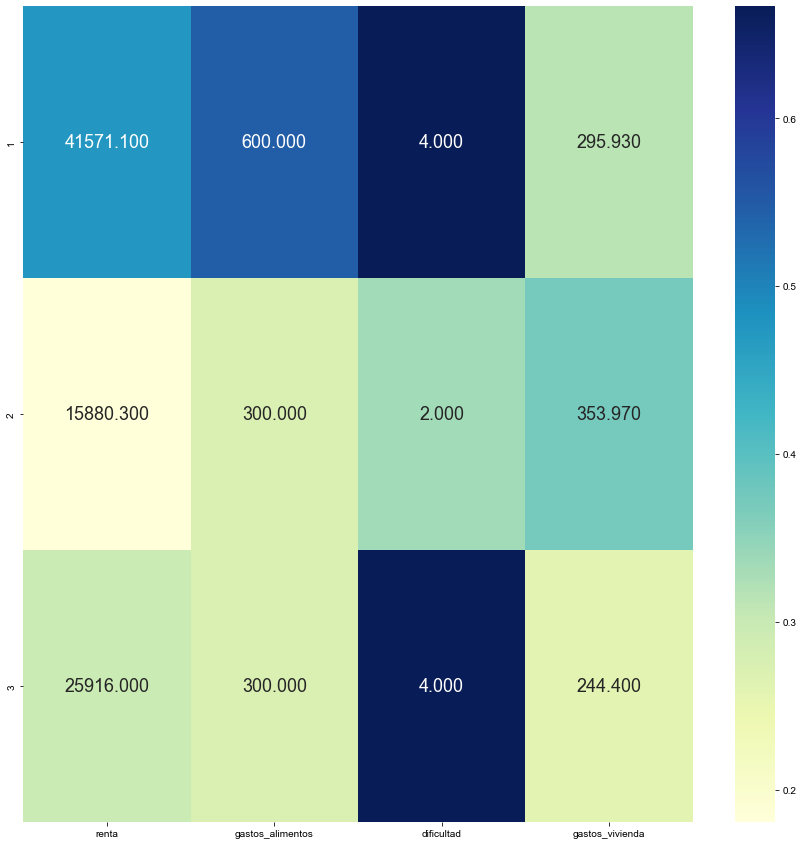

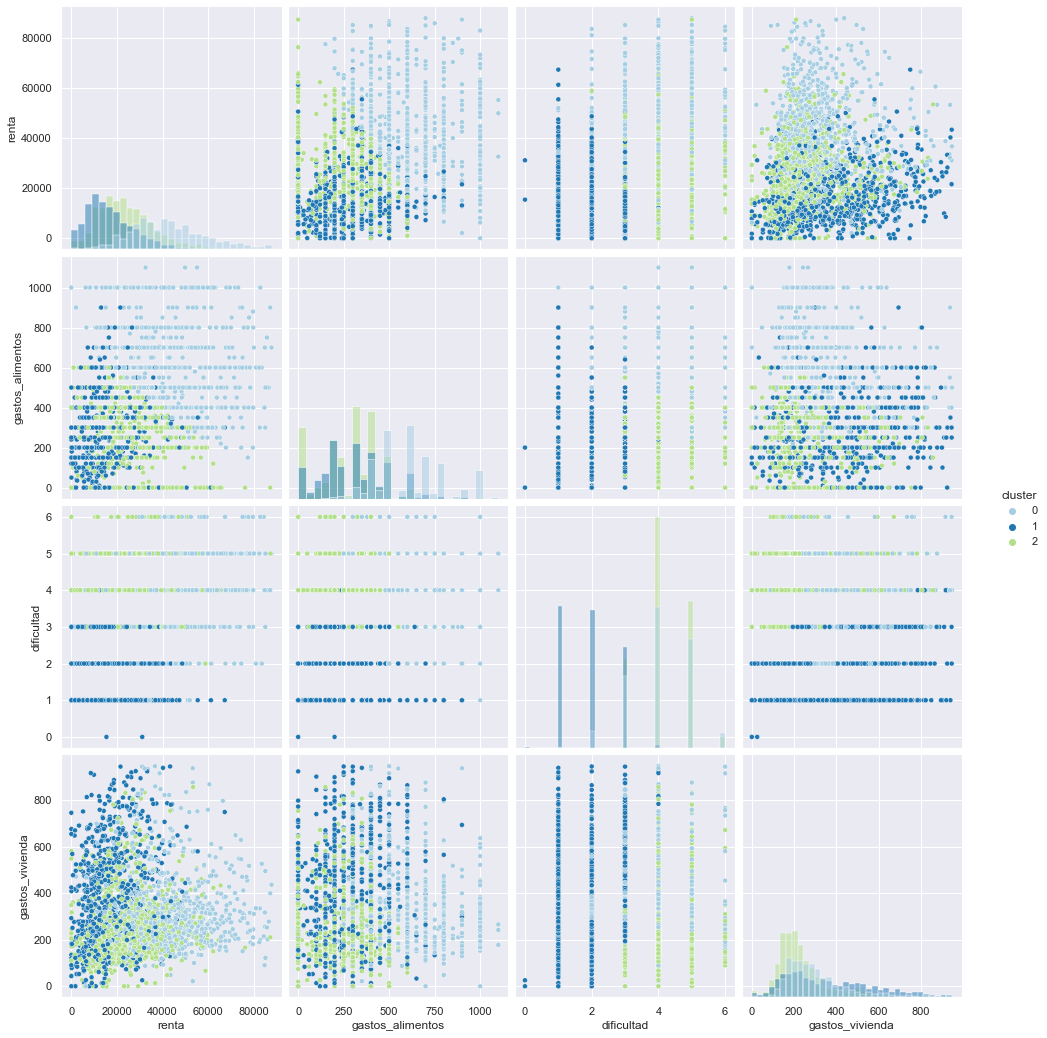

---------- Distribución por variable y cluster...
---------- Boxplots...
---------- Distancia intercluster...


<Figure size 432x288 with 0 Axes>

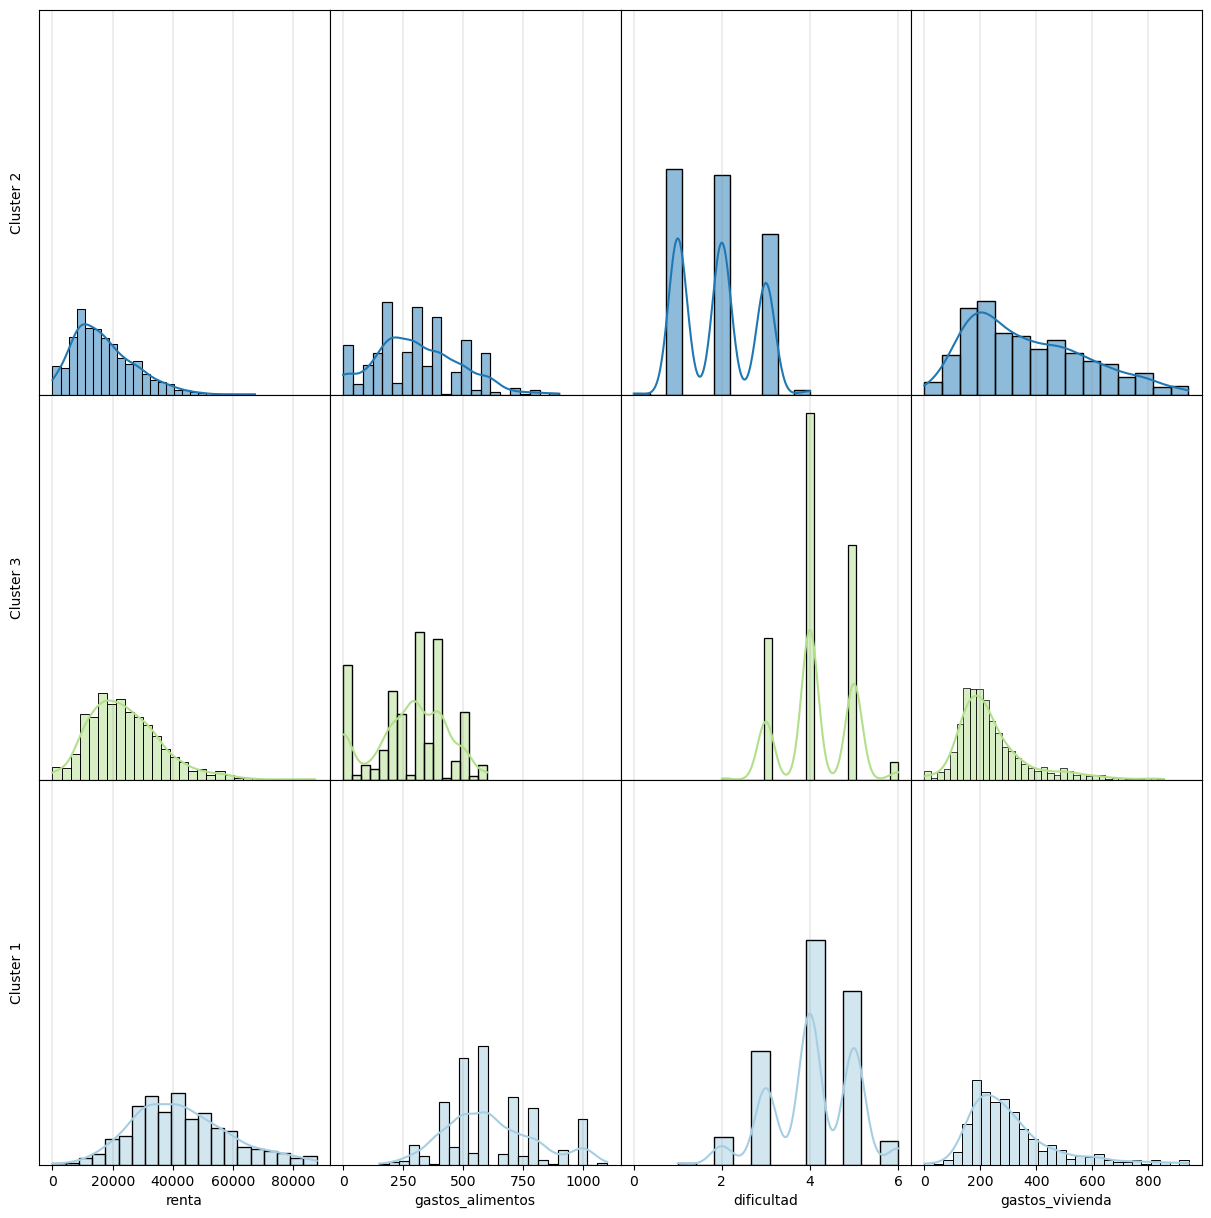

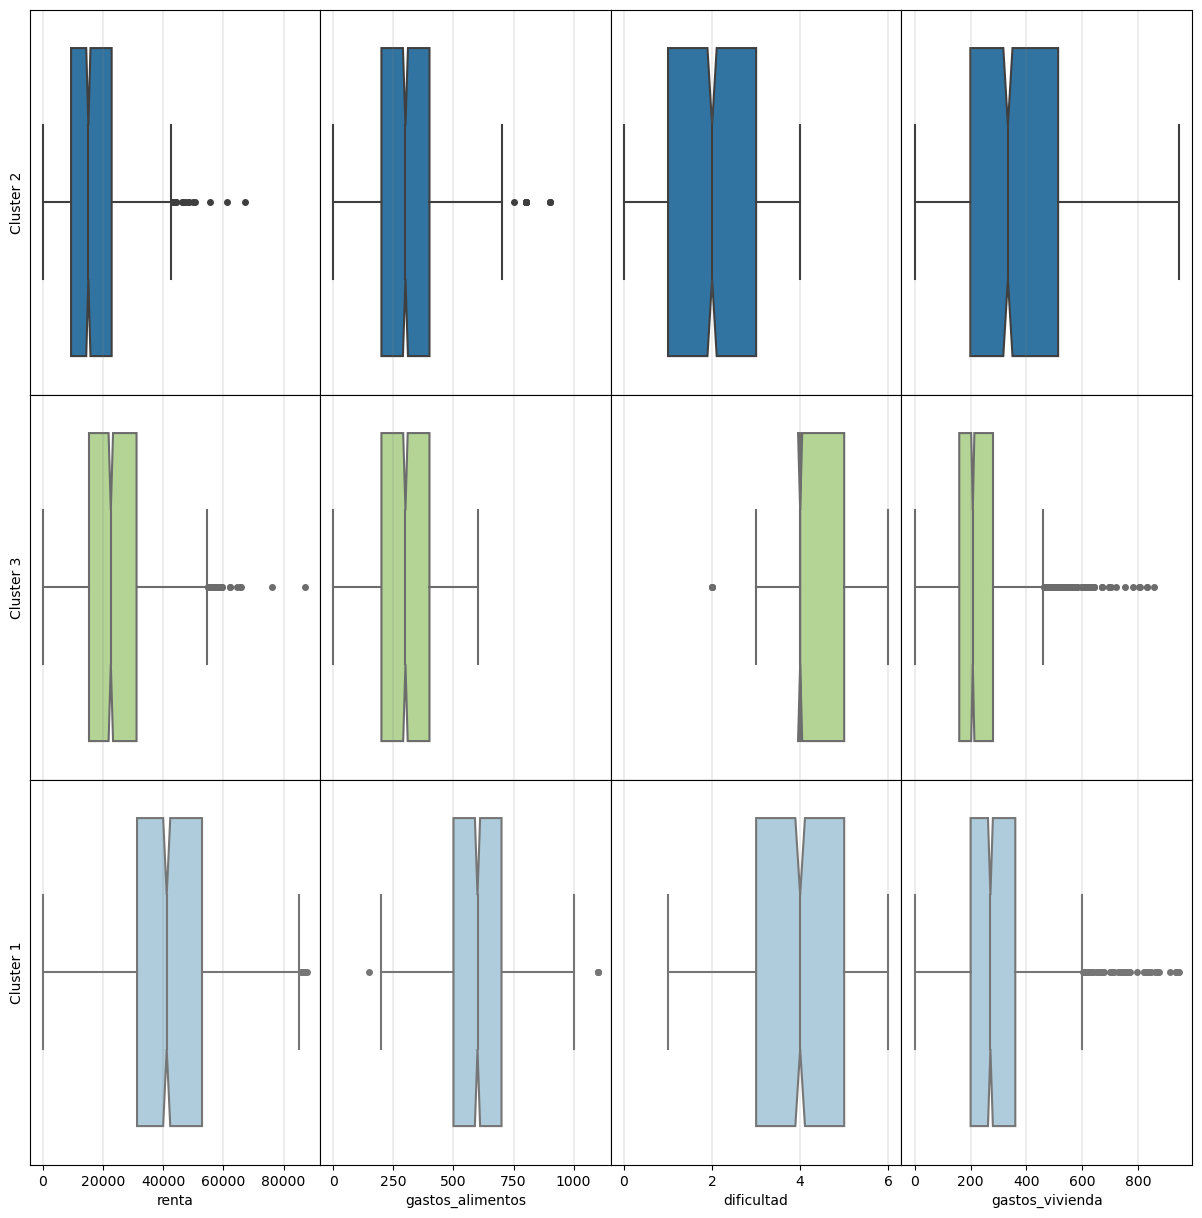

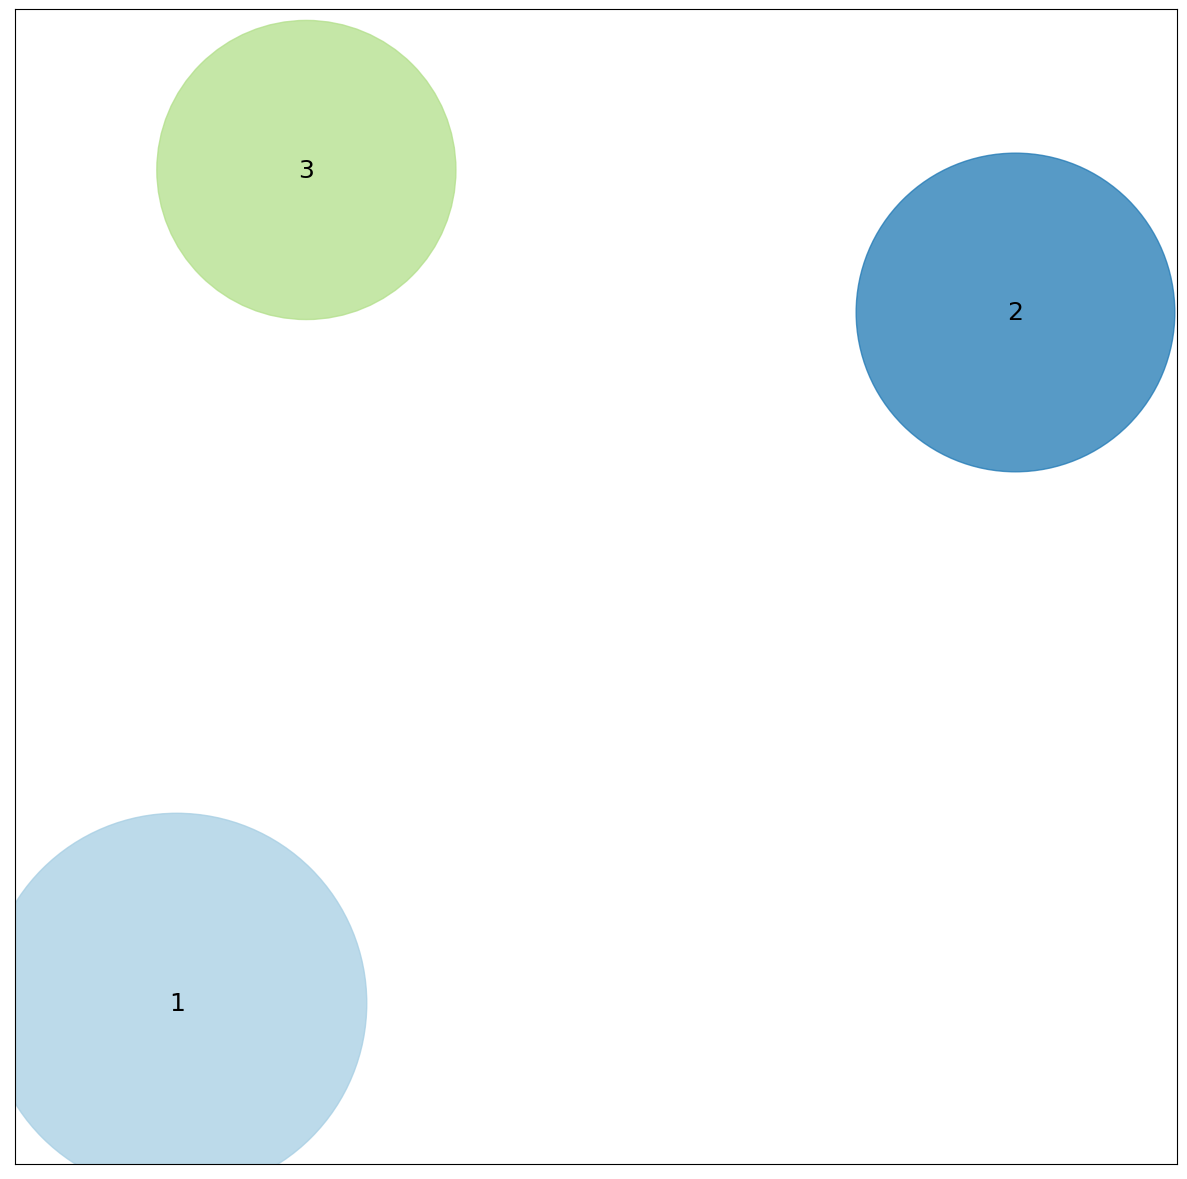

In [11]:
#kmeans(5,X_normal,X)
#birch(X_normal,X)
#dbscan(X_normal,X)
#meanshift(X_normal,X)
affinityPropagation(X_normal,X)